In [1]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\xiao\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##Exploration

In [2]:
from datasets import load_dataset
import torch
from tqdm import tqdm

wiki = load_dataset("wikitext", "wikitext-2-raw-v1")

train = wiki['train']['text']
test = wiki['test']['text']
val = wiki['validation']['text']

**DATA PREDICTION**

#Data preprocess

In [13]:
import re
# train 0-51 是第一个名词解释
# 大标题存一个，小标题存一个
def PreprocessTitle(dataset):
    filter_set = list(filter(lambda element: element != '', dataset))
    title_position = 0
    dealt_set = []
    title_content = ""
    for i,j in enumerate(filter_set):
        pattern_s = re.compile(r'@\W@')
        s_flag = pattern_s.search(j)
        if s_flag:
          filter_set[i] = re.sub(r' @(\W)@ ',r'\1',filter_set[i])
        pattern = re.compile(r'^ = .+ = \n$')
        result = pattern.match(j)
        if result:
            final_string = ""
            for k in range(title_position,i):
                if k == title_position:
                    pattern2 = re.compile(r'^ = = .+ = = \n$')
                    result2 = pattern2.match(filter_set[k])
                    #如果是两个=起步，说明是小标题，需要加上大标题，如果不是两个，那就是大标题普通处理
                    if result2:
                        temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        temp = re.sub(r'\n$', ':', temp)
                        # 去除所有=的情况
                        # temp = re.sub(r' (\w)', f'{title_content}\\1', filter_set[k],count=1)
                        # temp = re.sub(r'\n$', '', temp)
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                    else:
                        # 用 : 分隔了大标题和小标题，如果有影响可以改
                        temp = re.sub(r'\n$', ':', filter_set[k])
                        title_content = re.sub(r'^ = ', ' ', temp)
                        title_content = re.sub(r' = :$', ' : ', title_content)
                        # 去除所有=的情况
                        # temp = re.sub(r'\n$', '', filter_set[k])
                        # temp = " "+ temp.strip(' =')+ " "
                        # temp = temp + ": "
                        # title_content = temp
                        # temp = re.sub(r': $', ':', temp)
                    final_string = final_string + temp
                else:
                    temp = re.sub(r'\n$', '', filter_set[k])  # 内容以" . "结尾，所以最终会变成 " .  "（两个空格）
                    final_string = final_string + temp
            pattern_empty = re.compile(r':$')
            flag = pattern_empty.search(final_string)
            if flag:
              pass
            else:
              dealt_set.append(final_string)
            title_position = i

    dealt_set = [s for s in dealt_set if s.strip() != ""] #删除空值
    return dealt_set
    # @-@ 是wiki里用来表示-的方式： role @-@ playing 实际上是 role-playing

In [14]:
dealt_train = PreprocessTitle(train)
dealt_test = PreprocessTitle(test)
dealt_val = PreprocessTitle(val)
for i in dealt_train[:25]:
  print(i[:100])

 = Valkyria Chronicles III = : Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 
 = = Valkyria Chronicles III : Gameplay = = : As with previous Valkyira Chronicles games , Valkyria 
 = = Valkyria Chronicles III : Plot = = : The game takes place during the Second Europan War . Galli
 = = Valkyria Chronicles III : Development = = : Concept work for Valkyria Chronicles III began afte
 = = = Valkyria Chronicles III : Music = = = : The music was composed by Hitoshi Sakimoto , who had 
 = = = Valkyria Chronicles III : Release = = = : In September 2010 , a teaser website was revealed b
 = = Valkyria Chronicles III : Reception = = : On its day of release in Japan , Valkyria Chronicles 
 = = Valkyria Chronicles III : Legacy = = : Kurt and Riela were featured in the Nintendo 3DS crossov
 = = = Valkyria Chronicles III : Adaptations = = = : Valkyria Chronicles 3 was adapted into a two-ep
 = Tower Building of the Little Rock Arsenal = : The Tower Building of the Little Rock Arse

## GPT2

Parameters

In [8]:
batch_size = 2

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')

In [22]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [23]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=200):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [36]:
train_dataset = GPT2Dataset(dealt_train, tokenizer, max_length=500)
test_dataset = GPT2Dataset(dealt_test, tokenizer, max_length=500)
val_dataset = GPT2Dataset(dealt_val, tokenizer, max_length=500)

In [37]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [38]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [39]:
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda")
model.cuda()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50259, bias=False)
)

In [40]:
epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [41]:
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

c:\Users\xiao\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [43]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [44]:
print(len(train_dataloader))

2757


In [48]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()
    # pbar = tqdm(total=len(train_dataloader))

    for step, batch in tqdm(enumerate(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        loss.backward()

        optimizer.step()

        scheduler.step()

        # pbar.update(1)
    # pbar.close()

    avg_train_loss = total_train_loss / len(train_dataloader)

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


2757it [18:55,  2.43it/s]



  Average training loss: 2.32
  Training epoch took: 0:18:55

Running Validation...
  Validation Loss: 2.34
  Validation took: 0:01:06

======== Epoch 2 / 5 ========
Training...


2757it [22:27,  2.05it/s]



  Average training loss: 2.01
  Training epoch took: 0:22:28

Running Validation...
  Validation Loss: 2.42
  Validation took: 0:01:11

======== Epoch 3 / 5 ========
Training...


2757it [31:25,  1.46it/s]



  Average training loss: 1.72
  Training epoch took: 0:31:25

Running Validation...
  Validation Loss: 2.50
  Validation took: 0:01:13

======== Epoch 4 / 5 ========
Training...


2757it [26:34,  1.73it/s]



  Average training loss: 1.39
  Training epoch took: 0:26:35

Running Validation...
  Validation Loss: 2.62
  Validation took: 0:01:05

======== Epoch 5 / 5 ========
Training...


2757it [20:50,  2.20it/s]



  Average training loss: 1.10
  Training epoch took: 0:20:51

Running Validation...
  Validation Loss: 2.82
  Validation took: 0:01:20

Training complete!
Total training took 2:06:09 (h:mm:ss)


Let's view the summary of the training process.

In [50]:
# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.32,2.34,0:18:55,0:01:06
2,2.01,2.42,0:22:28,0:01:11
3,1.72,2.50,0:31:25,0:01:13
4,1.39,2.62,0:26:35,0:01:05
5,1.10,2.82,0:20:51,0:01:20


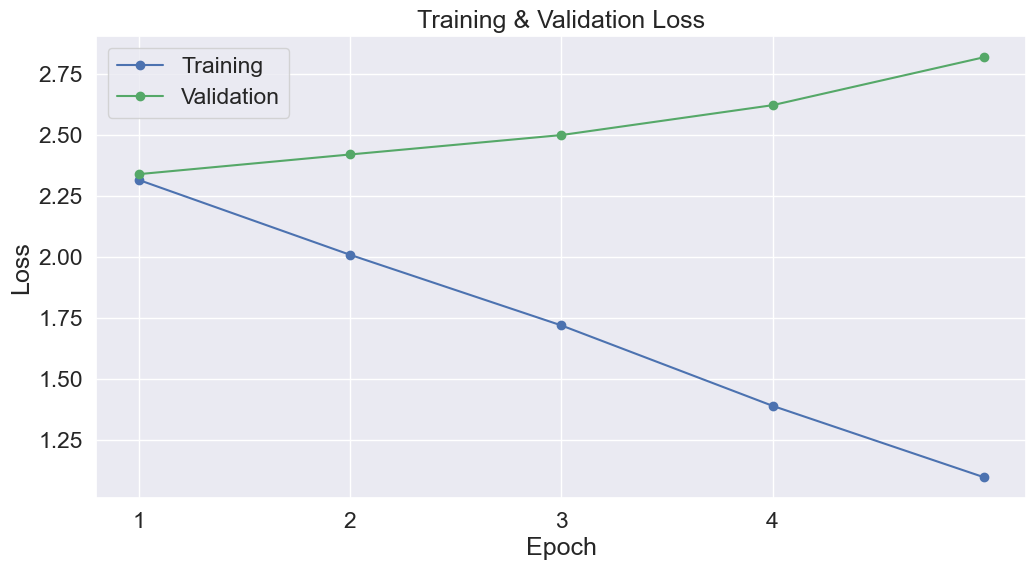

In [51]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [52]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

Save the trained model

In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# Pay attention to save file path !!!!! Avoid overwriting !!!
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)



# Save Fine-Tuned Model


# Generate Text

In [5]:
model.eval()

prompt = "<|startoftext|> = Soap = :"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                do_sample=True,
                                top_k=1000,
                                max_length = 1000,
                                top_p=2,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   796,  1406,   499,   796,  1058]], device='cuda:0')
0:  = Soap = : " Soap " is the fourth episode of the fifth season of the American comedy television series The Office, and the 197th episode overall. It originally aired on NBC in the United States on January 10, 2010, and on BBC in the United Kingdom on May 6, 2010. The episode features cast and crew as President Bart, Lee Morrissey as Skipper, Martin Short as Bracknell, Gil as Dwight, Pam Beesly as Harmony Chase, Anne Phianne as Mrs. Robinson, Michael Schur as Richard Wintory, David Scardino as Rex, Michael Scian as himself, and Kwesi as his nemesis.  Set in the South Pacific, the episode chronicles the everyday lives of office employees in the Scissor and Dwight offices, and explores themes related to posturing and subparment in the Scissor's management. In the episode, there is special rivalry between Oscar Martinez and Ceasar Dean, as the latter is physically ill and mentally exhausted and so comes to mind havin

Perplexity

In [56]:
max_length = model.config.n_positions
stride = 512

def ppl(model, input_ids_all, stride):
  nlls = []
  for i in tqdm(range(0, input_ids_all.size(1), stride)):
      begin_loc = max(i + stride - max_length, 0)
      end_loc = min(i + stride, input_ids_all.size(1))
      trg_len = end_loc - i  # may be different from stride on last loop
      input_ids = input_ids_all[:, begin_loc:end_loc].to("cuda:0")
      target_ids = input_ids.clone()
      target_ids[:, :-trg_len] = -100

      with torch.no_grad():
          outputs = model(input_ids, labels=target_ids)
          neg_log_likelihood = outputs[0] * trg_len

      nlls.append(neg_log_likelihood)

  ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
  return ppl

In [57]:
encodings = tokenizer("\n\n".join(dealt_test), return_tensors="pt")
ppl(model, encodings.input_ids, stride)

Token indices sequence length is longer than the specified maximum sequence length for this model (277118 > 1024). Running this sequence through the model will result in indexing errors
100%|██████████| 542/542 [02:35<00:00,  3.48it/s]


tensor(89.5509, device='cuda:0')